# Exploring the Limitations of the Open Data for Research

An important point about the published research data is that, although they are intended for scientific studies, they still have limitations. It is important to keep in mind the limitations of these datasets when in use to avoid false-positive results or dead ends. 

Some of the most important limitations are described in the [documentation of each dataset](https://opendata.atlas.cern/docs/category/data-for-research). In this notebook we are going to explore some of the limitations for each dataset.


If you have any questions about whether a particular analysis is possible please feel free to [contact us](https://opendata.atlas.cern/contact-us). In case the analysis is not possible with the available public data, you are also welcome to consider a [short term association with ATLAS](https://atlas.cern/Discover/Collaboration/External-Collaboration) in order to perform the analysis like a member of the collaboration would.

In [1]:
# If not you are not running on myBinder, uncomment and run the following to install atlasopenmagic
# %pip install atlasopenmagic
# from atlasopenmagic import install_from_environment
# install_from_environment()

In [1]:
# In case any of these imports fails, please restart the jupyter kernel and try again - it is likely the environment just needs to be updated
import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import tqdm # progress bars
import numpy as np  # arrays and math
import atlasopenmagic as atom # ATLAS Open Data package

import socket
#Set a longer timeout (default is often too short)
socket.setdefaulttimeout(60) # 60 seconds

## General remarks
To use our samples, there are some things you should have in mind to avoid inconsistencies:
- Always use data listed in the [Good Runs List (GRL)](https://opendata.atlas.cern/docs/documentation/data_collection/GRL_definition). In the GRL you will find information about good runs and good lumiblocks (LBs), which means that the data taken in certain period of time is good to be used in analysis. This is the only way we have to assure you of the quality of the data.
- Some signals/variations/systematics are not publicly released: if you need a specific sample, you can request it.
- Producing large bespoke MC yourself is possible but discouraged, as it is resource-heavy, and easy to mismatch conditions.

Regarding the first point, we can explore the GRL and filter data with measured in good runs and good lumiblocks. We are going to do it with proton-proton collisions data, but this also applies to heavy ion data.

In [3]:
# The default release in the package is pp collisions at 13.6 TeV
atom.get_current_release()

'2024r-pp'

The GRL are publicly available [here](cern.ch). There are two files for the proton-proton data corresponding to 2015 and 2016 runs, and one for the HI collisions. They are saved in .xml format. The data for each run with its LB's looks something like this:
```xml
<LumiBlockCollection>
<Run>276262</Run>
<LBRange Start="72" End="84"/>
<LBRange Start="86" End="110"/>
<LBRange Start="118" End="288"/>
<LBRange Start="292" End="379"/>
</LumiBlockCollection>
```
We can parse it into a dictionary to be able to iterate in a simpler way.

In [4]:
import xml.etree.ElementTree as ET

def grl_parser(xml_file):
    # We are going to use this function to parse the GRL .xml file

    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Dict: run_number -> list of (start_lb, end_lb)
    runs_to_lbs = {}

    # find the begining and end of the file
    named = root.find("NamedLumiRange")
    # each run+LBs is in a LumiBlockCollection
    for lbcoll in named.findall("LumiBlockCollection"): 
        run = int(lbcoll.find("Run").text)  # get the run number

        lb_ranges = []
        for lbrange in lbcoll.findall("LBRange"): # get the LB ranges
            start = int(lbrange.attrib["Start"])
            end = int(lbrange.attrib["End"])
            lb_ranges.append((start, end))
        
        # map run number to its LB ranges
        runs_to_lbs[run] = lb_ranges 
    
    return runs_to_lbs

Now, let's look at the GRL for the 2015 run:

In [5]:
# let's pretty print the GRL dictionary
import pprint
pp = pprint.PrettyPrinter()
grl15_dict = grl_parser("data15_13TeV.periodAllYear_DetStatus-v89-pro21-02_Unknown_PHYS_StandardGRL_All_Good_25ns.xml")
pp.pprint(grl15_dict)

{276262: [(72, 84), (86, 110), (118, 288), (292, 379)],
 276329: [(147, 558)],
 276336: [(4, 15), (36, 54)],
 276416: [(373, 418), (445, 508)],
 276511: [(185, 476)],
 276689: [(198, 214), (216, 464)],
 276778: [(177, 193)],
 276790: [(251, 286)],
 276952: [(75, 214)],
 276954: [(208, 224)],
 278880: [(101, 149), (152, 211), (213, 391), (404, 509), (511, 578)],
 278912: [(119, 515), (518, 530)],
 278968: [(40, 128), (131, 160), (163, 167)],
 279169: [(292, 1056), (1058, 1082)],
 279259: [(425, 526)],
 279279: [(291, 393), (395, 399), (404, 453), (498, 510), (515, 571)],
 279284: [(427, 882)],
 279345: [(99, 487), (489, 491), (496, 499), (502, 665), (667, 734)],
 279515: [(483, 487)],
 279598: [(605, 767),
          (769, 770),
          (772, 906),
          (909, 922),
          (924, 1302),
          (1304, 1307)],
 279685: [(238, 585),
          (587, 696),
          (698, 706),
          (708, 830),
          (832, 851),
          (853, 860),
          (878, 1027),
          (1035,

We want to look at the detector data files from 2015 and check that:
- Each event is part of a good run.
- Each event is within a lumiblock range listed in this dictionary.

The run number is in the `EventInfo` tree, under `runNumber`. The LBs are under `lumiBlock`

We can do a simple check for the run number:

In [6]:
# Get a list with all the data samples
data_urls = atom.get_urls('data', protocol='https', cache=True)

In [7]:
# Let's look at the first file
tree = uproot.open({data_urls[0]: "CollectionTree"})
print(f'The file in "{data_urls[0]}" \ncontains the following run number:')
runnumber = tree["EventInfoAuxDyn.runNumber"].array()
print(runnumber)

The file in "simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000001.pool.root.1" 
contains the following run number:
[266904, 266904, 266904, 266904, 266904, ..., 266904, 266904, 266904, 266904]


In this case, the run numbers for all the events extracted from `EventInfoAuxDyn.runNumber` are the same (you can check that youserlf). We can compare with the run numbers in the GRL we parsed above.

In [8]:
# Convert the run numbers, which are the keys in our GRL dict, to a list
grl15 = list(grl15_dict.keys())
runnumber[0] in grl15

False

The data in this particular file was not recorded during a good run, so we don't want to use it for analysis. For one that is part of a good run list, we have to check the lumiblock of each event. We are going to use URL 3007 in the list as an example:

In [9]:
tree = uproot.open({data_urls[3007]: "CollectionTree"})
# Get all the event info
print("Analyzing file: DAOD_PHYSLITE.37001747._000026.pool.root.1")
print("_"*75)
runnumber = tree["EventInfoAuxDyn.runNumber"].array()
# Check unique run numbers
unique_runnumber = np.unique(ak.to_numpy(runnumber))
print("Unique run numbers:", unique_runnumber)
lumiblock = tree["EventInfoAuxDyn.lumiBlock"].array()
# Check unique lumiblocks
unique_lbs = np.unique(ak.to_numpy(lumiblock))
print("Unique lumiblocks:", unique_lbs)
eventnumber = tree["EventInfoAuxDyn.eventNumber"].array()
# Verify that the run number is in the GRL
print("_"*75)
if runnumber[0] not in grl15:
    print("Run number not in GRL 2015!")
else: 
    print("Run number is in GRL 2015!")
    lumiblos_grl15 = grl15_dict[runnumber[0]]
    # We will record the event number (as IDs) for the good events
    good_eventnumbers = []
    # Loop over all lumiblocks
    for ev, lb in zip(eventnumber, lumiblock):
        in_good_range = False
        for start, end in lumiblos_grl15:
            if start <= lb <= end:
                in_good_range = True
                break   # no need to check other ranges after found
        
        # if in good range, save event number
        if in_good_range:
            good_eventnumbers.append(ev)

print("Number of good events:", len(good_eventnumbers), "\nTotal number of events checked:", len(eventnumber))
print("_"*75)
print('Check for consistency:')
print(f"Lumiblocks for run number (should cover unique lumiblocks): {grl15_dict[runnumber[0]]}")

Analyzing file: DAOD_PHYSLITE.37001747._000026.pool.root.1
___________________________________________________________________________
Unique run numbers: [279259]
Unique lumiblocks: [523 524 525 526]
___________________________________________________________________________
Run number is in GRL 2015!
Number of good events: 142128 
Total number of events checked: 142128
___________________________________________________________________________
Check for consistency:
Lumiblocks for run number (should cover unique lumiblocks): [(425, 526)]


And just like that, we checked that the quality of the dataset is suitable for physics analysis!

In [10]:
# Removing tree from memory to free up resources
del tree

## Proton-proton data
The scope of the proton-proton data is limited by the group of samples that is public. Public samples cover standard backgrounds and generic systematics. However, key systematics may be missing (e.g., heavy-quark fragmentation for top-mass), as well as many signal/variation grids that are not released (e.g., W-mass templates, broad BSM scans)

We encourage reaching out in case you are missing a sample. Requests will be considered in a case-by-case basis.

### PHYSLITE format
Proton-proton collisions are stored in a PHYSLITE format file. This format is aimed to support “standard” object selections and workflows. Non-standard object definitions/reconstruction is generally not supported. For example, not all charged tracks are available; neither are all calo clusters or PFlow objects. 

Let's expand on this last point by looking at the tracks.

In [ ]:
# We are using 410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad
urls_sample = atom.get_urls(410470, protocol='https', cache=True)
filename = urls_sample[0]
#filename = 'DAOD_PHYSLITE.37620644._000012.pool.root.1'  # Local
tree = uproot.open({filename: "CollectionTree"})

To look at the available tracks, we will use `IntDetTrackParticles` branch, which holds the inner detector tracks.

In [3]:
# IntDetTrack branch
intdettrack = list(tree.keys())[978:1000]
tree.show(filter_name=intdettrack, name_width=50, typename_width=50, interpretation_width=50)

name                                               | typename                                           | interpretation                                    
---------------------------------------------------+----------------------------------------------------+---------------------------------------------------
InDetTrackParticlesAuxDyn.truthParticleLink        | vector<ElementLink<DataVector<xAOD::TruthPartic... | AsGroup(<TBranchElement 'InDetTrackParticlesAux...
InDetTrackParticlesAuxDyn.truthParticleLink/InD... | uint32_t[]                                         | AsJagged(AsDtype('>u4'))
InDetTrackParticlesAuxDyn.truthParticleLink/InD... | uint32_t[]                                         | AsJagged(AsDtype('>u4'))
InDetTrackParticlesAuxDyn.numberOfPixelHits        | std::vector<uint8_t>                               | AsJagged(AsDtype('uint8'), header_bytes=10)
InDetTrackParticlesAuxDyn.numberOfPixelHoles       | std::vector<uint8_t>                               | AsJagged(As

Let's see the distributions of tracks, i.e. the track multiplicity. We will use the variable `phi` to count the tracks, but any variable could be use.

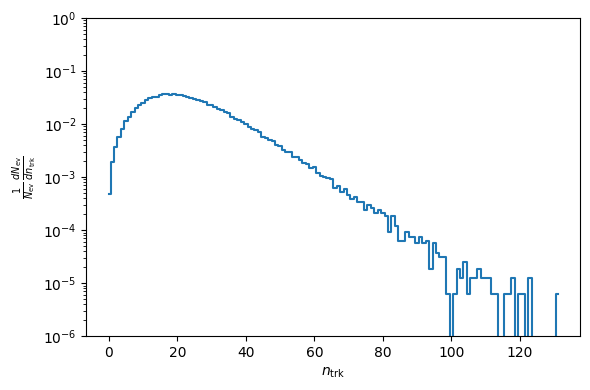

In [4]:
indet_n = tree["InDetTrackParticlesAuxDyn.phi"].array()
counts = ak.num(indet_n, axis=1)         # tracks per event
counts_np = ak.to_numpy(counts)

# bin edges: ..., 0.5, 1.5, 2.5, ...
bins = np.arange(counts_np.max() + 2) - 0.5

# number of events per multiplicity bin
hist, edges = np.histogram(counts_np, bins=bins)

N_ev = len(counts_np)
bin_centers = 0.5 * (edges[1:] + edges[:-1])

# normalize: 1/N_ev * dN/dn  (Δn = 1 so this is just fraction of events)
y = hist / N_ev

plt.figure(figsize=(6, 4))

# step plot vs bin centroid
plt.step(bin_centers, y, where="mid")

plt.yscale("log")
plt.ylim(1e-6, 1)
plt.xlabel(r"$n_{\mathrm{trk}}$")
plt.ylabel(r"$\frac{1}{N_\mathrm{ev}} \, \frac{dN_\mathrm{ev}}{dn_\mathrm{trk}}$")

plt.tight_layout()
plt.show()

We can compare with the multiplicity from [Charged-particle distributions in s=√13 TeV pp interactions measured with the ATLAS detector at the LHC](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/STDM-2015-02/) and see that in general we have fewer tracks in a PHYSLITE file.

<img src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/STDM-2015-02/fig_03c.png" width="50%">


We can check at the pT distribution for this tracks using `qOverP` and `theta`. Due to the limited set of tracks available in this sample, the pT spectrum is distorted and can show artificial structures (gaps) that are not physical.

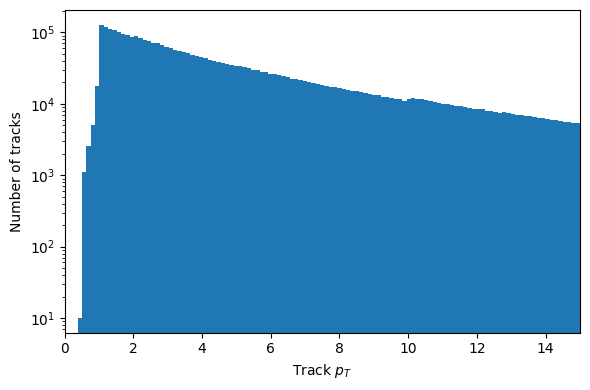

In [11]:
# Track parameters (jagged: one array per event)
qoverp = tree["InDetTrackParticlesAuxDyn.qOverP"].array()
theta  = tree["InDetTrackParticlesAuxDyn.theta"].array()

# Compute pT per track:
# p  = 1 / |q/p|
# pT = p * sin(theta) = sin(theta) / |q/p|
pt = np.sin(theta) / np.abs(qoverp)   

pt_GeV = pt * 1e-3

mask = pt_GeV < 10000000.0
pt_good = pt_GeV[mask]

# Flatten to 1D array of all tracks
pt_flat = ak.to_numpy(ak.flatten(pt_good))

# Define bins from 0 up to the maximum pT
pt_max = 15
n_bins = 30*4
bins = np.linspace(0, pt_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(pt_flat, bins=bins)

plt.xlabel(r"Track $p_T$")  # units depend on qOverP convention (GeV or MeV)
plt.ylabel("Number of tracks")

plt.xlim(0,15)
plt.yscale('log')
plt.tight_layout()
plt.show()

We can compare this with the pT of the tracks obtained from a the AOD, a more inclusive format.

<img src="trackptfromAOD.png" width="50%">

If you **want to look further** you can plot the distribution of calocluster objects; not all are saved in the PHYSLITE format.

After checking that the PHYSLITE format does *not* keep all reconstructed tracks, we can also look at where the vertices that are stored actually sit in the detector. Here I plot the radial position of the hard scatter vertices and the primary vertices. The left panel shows the full distribution; the right panel zooms into the region around the beam line.

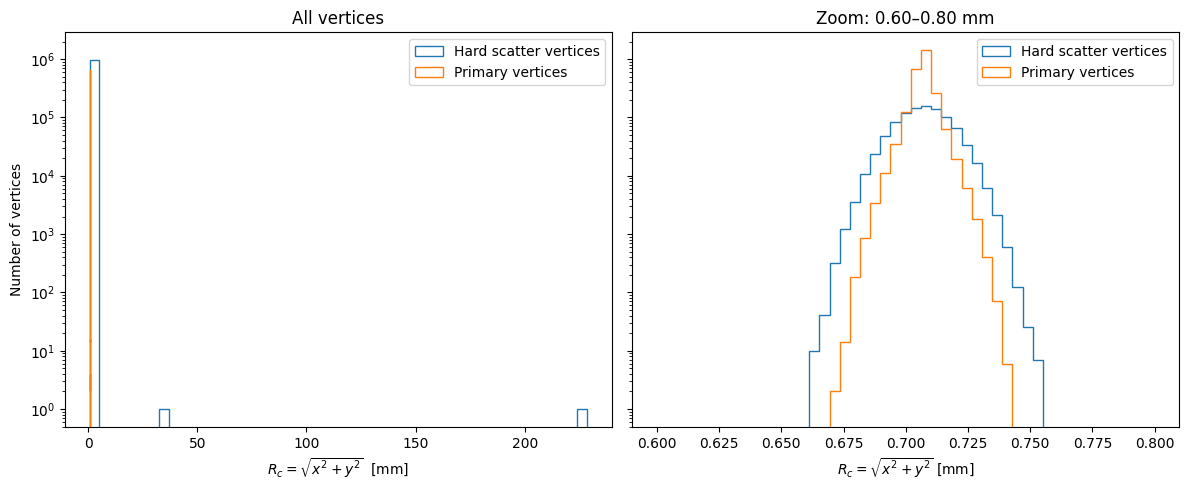

In [ ]:
# get coordinates
hs_x = tree["HardScatterVerticesAuxDyn.x"].array()
hs_y = tree["HardScatterVerticesAuxDyn.y"].array()
pv_x = tree["PrimaryVerticesAuxDyn.x"].array()
pv_y = tree["PrimaryVerticesAuxDyn.y"].array()

# Rc = sqrt(x^2 + y^2)
hs_rc = np.sqrt(hs_x**2 + hs_y**2)
pv_rc = np.sqrt(pv_x**2 + pv_y**2)

hs_rc_flat = ak.to_numpy(ak.flatten(hs_rc))
pv_rc_flat = ak.to_numpy(ak.flatten(pv_rc))

# selection for the zoomed region
hs_sel = hs_rc_flat[(hs_rc_flat > 0) & (hs_rc_flat < 2.0)]
pv_sel = pv_rc_flat[(pv_rc_flat > 0) & (pv_rc_flat < 2.0)]

# binning
bins_full = 50
bins_zoom = np.linspace(0.60, 0.80, 50)

# make grid of plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# left: full range
ax1.hist(hs_rc_flat, bins=bins_full, histtype="step", label="Hard scatter vertices")
ax1.hist(pv_rc_flat, bins=bins_full, histtype="step", label="Primary vertices")
ax1.set_xlabel(r"$R_c = \sqrt{x^2 + y^2}$  [mm]")
ax1.set_ylabel("Number of vertices")
ax1.set_yscale("log")
ax1.legend()
ax1.set_title("All vertices")

# right: zoomed range
ax2.hist(hs_sel, bins=bins_zoom, histtype="step", label="Hard scatter vertices")
ax2.hist(pv_sel, bins=bins_zoom, histtype="step", label="Primary vertices")
ax2.set_xlabel(r"$R_c = \sqrt{x^2 + y^2}$ [mm]")
ax2.set_yscale("log")
ax2.legend()
ax2.set_title("Zoom: 0.60–0.80 mm")

plt.tight_layout()
plt.show()

Two things are worth noting:
- We don’t see vertices at large radius: everything is concentrated very close to the nominal interaction region.
- The peak is not at Rc = 0, but around ∼0.7 mm, so the “usual” vertex position is slightly offset from the detector centre. This is expected from real beam spot.

This is what we want for standard analyses, but it also reveals a limitation of this dataset, since vertices that are further displaced from the beam line (mm or cm scale) are not stored.

Since the file only contains prompt hard scatter/primary vertices, e.g. LLP signatures that rely on reconstructing highly displaced vertices cannot be studied with a PHYSLITE sample.

In [16]:
# Removing variables from memory to free up resources
del tree, qoverp, theta, pt, pt_good, pt_flat

## Heavy ions
For heavy ion collisions, as for proton–proton data, what you can do is ultimately constrained by the selected data that have been released. The open heavy ion data includes a single Monte Carlo sample, designed to represent minimum bias heavy ion events in the detector. Its mainly aimed to support generic studies, such as checking tracking performance and efficiencies.

While, in theory, users can generate their own simulated samples, this is a non-trivial task and is not recommended. Within the collaboration, large dedicated workflows are used to produce simulations that reproduce details such as the detector conditions and the pileup profile of a given data-taking period. Achieving a similar level of accuracy would require substantial support and an unrealistic amount of time.

### HION14 format
The data was releases in [HION14](https://opendata.atlas.cern/docs/documentation/data_format/HI_formats) heavy ion collision data format. It does not contain all physics objects (like jets or electrons), nor all calorimeter objects or particle flow objects. As a result, some analyses cannot be performed. For example:

- Analyses requiring detailed calorimeter information (e.g. calorimeter-based energy flow analyses)
- Analyses requiring jets in any way (e.g. studies of jet suppression or jet cross-sections)
- Analyses examining lepton universality (e.g. Z-boson decays to electrons and muons)

The HION14 data format is constructed to support "standard" track-based analyses. This also implies that analyses requiring non-standard configurations of specific tools may be difficult or impossible. For example:

- Measurements and searches with non-standard physics object definitions or reconstruction (e.g. customized heavy-flavor hadron tagging, modified photon reconstruction) are not possible
- Measurements using information from the forward detectors in ATLAS are not currently supported (e.g. some diffractive physics measurements using information from the zero-degree calorimeter)

One way to see the limitations of using the HION14 format is examining the number of primary vertices per event. The HION14 format retains a single hard scatter vertex, which we can verify by loading the heavy ion release using `atlasopenmagic` and counting the vertices in the detector data.

In [17]:
# To check the available releases use
# atom.available_releases()
atom.set_release('2024r-hi')

Fetching metadata for release: 2024r-hi...
Fetching datasets: 100%|██████████| 2/2 [00:00<00:00, 45.50datasets/s]
✓ Successfully cached 2 datasets.
Active release: 2024r-hi. (Datasets path: REMOTE)


In [18]:
hi_data = atom.get_urls('data', protocol='https', cache=True)[0]
tree = uproot.open({hi_data: "CollectionTree"})

Primary vertices can be found in the `PrimaryVertices` tree. We are using the `vertexType` variable, which contains integers defining the type of vertex created in the offline reconstruction. We are looking after `vertexType==1` according to the following enumeration:
- **0**: Dummy vertex, TrackParticle was not used in vertex fit
- **1**: Primary Vertex
- **2**: Secondary Vertex
- **3**: Pile Up Vertex


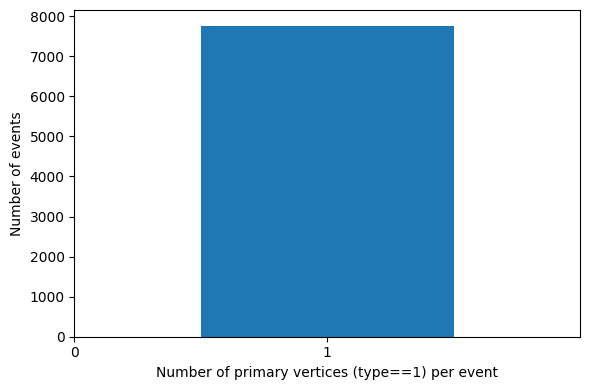

In [19]:
# vertexType per event
vtx_type = tree["PrimaryVerticesAuxDyn.vertexType"].array()

# count how many vertices have type == 1 in each event (the "hard scatter" vertex)
counts_type1 = ak.sum(vtx_type == 1, axis=1)
counts_np = ak.to_numpy(counts_type1)

plt.figure(figsize=(6, 4))

# integer binning centered on integers
bins = np.arange(counts_np.max() + 2) - 0.5
plt.hist(counts_np, bins=bins)

plt.xlabel("Number of primary vertices (type==1) per event")
plt.ylabel("Number of events")

# show only ~10 ticks max
step = max(1, counts_np.max() // 10)
plt.xticks(np.arange(0, counts_np.max() + 1, step))

plt.xlim(0, counts_np.max() + 1)

plt.tight_layout()
plt.show()


From this plot we see that each event contains exactly one reconstructed primary vertex. This is not a property of the heavy ion collisions, but a consequence of the HION14 format: only a single hard-scatter vertex is kept, and any additional vertex information is discarded. 

This is convenient for simple, track analyses, but it also introduces limitations:
- Vertex reconstruction performance cannot be studied, 
- Exploring rare events with multiple vertices is not possible
- Vertex multiplicity and structure as an additional observable to characterize the event or reject backgrounds is also not possible. 

In [20]:
# Removing tree from memory to free up resources
del tree

## Event generation
The samples that have been released are sufficient to establish standard backgrounds and generically-applicable systematic uncertainties. In some cases, establishing key systematic uncertainties requires additional samples that have not been released (e.g. heavy quark fragmentation variations for top mass measurements). Some signal samples or variation samples have also not been released in order to reduce the total space required by the samples (e.g. W-boson mass variation samples that are required for a template fit to the W-boson mass, or a wide variety of beyond-the-Standard-Model signal samples that are used in various searches for new particles).

Again, in principle it's possible to produce your own samples. The tutorials provided by the collaboration provide instructions for doing so. In case issues are encountered, you are welcome to get in touch with us for assistance. Of course, the collaboration has significant computing resources that have been used for the production of very large samples. It can be difficult for individuals to produce a comparable number of events, and it can be quite wasteful in case the reproduction duplicates what has already been done internally.

In case there are specific samples that would be beneficial to your analysis or work, you are welcome to [request their release](https://opendata.atlas.cern/contact-us).

### HEPMC2 format
The [HEPMC2](https://cds.cern.ch/record/684090/) event-generation data format released for research use contains all particles in the event record, slightly modified from what the generator would normally provide. In particular:

- Loops in the event record have been broken apart.
- The events have been checked for unexpected features (like stable gluons), and any such events have been removed. These can result from rare issues in specific event generators.

The data format is without any detector simulation applied. It is necessary to apply some smearing and inefficiencies to the particle records before comparing them to reconstructed data. Doing so is rather delicate, but standard programs like DELPHES and PGS, as well as Rivet functionality, should suffice for many cases.

To illustrate this, we will now use DELPHES to apply a simplified detector simulation to the HEPMC2 events and directly compare the resulting distributions to those obtained from the reconstructed Monte Carlo data, comming from the same sample.

In [21]:
%%capture
%pip install pyhepmc graphviz
%conda install --channel conda-forge delphes

Firts, let's process the event generation data. We set the 13.6 TeV data using the tag `2025r-evgen-13p6tev`.

In [22]:
atom.set_release('2025r-evgen-13p6tev')

Fetching metadata for release: 2025r-evgen-13p6tev...
Fetching datasets: 100%|██████████| 1509/1509 [00:02<00:00, 582.51datasets/s]
✓ Successfully cached 1509 datasets.
Active release: 2025r-evgen-13p6tev. (Datasets path: REMOTE)


We are using the sample 700793 for the $Z\rightarrow\tau\tau$ process


In [23]:
# We'll print all the metadata from the sample (cross section, k-factor, etc)
# We're going to use pretty print just to make it easy to read
import pprint
pprint.pp(atom.get_metadata('700793'))
# Get the URLs for the files in the dataset. We disable caching because we are
# going to download the files ourselves, by hand
my_urls = atom.get_urls('700793', protocol='https', cache=False)

{'dataset_number': '700793',
 'physics_short': 'Sh_2214_Ztautau_maxHTpTV2_CFilterBVeto',
 'e_tag': None,
 'cross_section_pb': 2337.4,
 'genFiltEff': 0.1303084,
 'kFactor': 1.0,
 'nEvents': 25000000,
 'sumOfWeights': None,
 'sumOfWeightsSquared': None,
 'process': None,
 'generator': 'Sherpa',
 'keywords': ['2lepton', '2tau', 'Baseline', 'jets', 'nlo', 'sm', 'z'],
 'description': 'Sherpa Z/gamma* -> tau tau + 0,1,2j@NLO + 3,4,5j@LO with '
                'c-jet filter taking input from existing unfiltered input '
                'file.',
 'job_path': 'https://gitlab.cern.ch/atlas-physics/pmg/mcjoboptions/-/blob/master/700xxx/700793/mc.Sh_2214_Ztautau_maxHTpTV2_CFilterBVeto.py',
 'CoMEnergy': 13600.0,
 'GenEvents': 186799340,
 'GenTune': 'NULL',
 'PDF': 'NULL',
 'Release': 'AthGeneration_23.6.3',
 'Filters': 'HeavyFlavorHadronFilter',
 'cross_section_uncertainty': 0.0,
 'hepmc_version': 2,
 'release': {'name': '2025r-evgen-13p6tev'}}


Now let's download that file locally. The files are about 2 GB, which takes about a couple of minutes to get to the node most of the time.

In [24]:
# Pull down the entire file using urllib's request functionality
import urllib.request
(local_filename,headers) = urllib.request.urlretrieve(my_urls[0])
# Use tarfile to get the HEPMC file out of the tar.gz file
import tarfile
with tarfile.open(local_filename, mode="r:gz") as tar_file:
    # There should be only one member - our hepmc file
    hepmc_file = tar_file.getmembers()[0]
    # Extract it!
    tar_file.extract(hepmc_file, filter='data')
print(f'Extracted {hepmc_file.name} from the tarfile')

Extracted HEPMC.44245572._000001.hepmc from the tarfile


We can do some simple detector simulation using [Delphes](https://github.com/delphes/delphes) as well. We will run one of the pre-defined analyses as an example. 

In the next cell we use Jupyter’s `%%bash` magic to run Delphes from the command line, since it has no Python API. We call the DelphesHepMC2 executable, which is the right one for our HepMC2 text event files. The configuration “cards” are taken from `${CONDA_PREFIX}`, where conda installed Delphes, and we use the default ATLAS card. Finally, we specify the Delphes output ROOT file name and pass the HEPMC input file name (via $1) from the notebook into the bash command.

In [25]:
%%bash -s {hepmc_file.name}
DelphesHepMC2 ${CONDA_PREFIX}/cards/delphes_card_ATLAS.tcl delphes_output.root $1

** INFO: adding module        ParticlePropagator       ParticlePropagator       
** INFO: adding module        Efficiency               ChargedHadronTrackingEfficiency
** INFO: adding module        Efficiency               ElectronTrackingEfficiency
** INFO: adding module        Efficiency               MuonTrackingEfficiency   
** INFO: adding module        MomentumSmearing         ChargedHadronMomentumSmearing
** INFO: adding module        MomentumSmearing         ElectronMomentumSmearing 
** INFO: adding module        MomentumSmearing         MuonMomentumSmearing     
** INFO: adding module        Merger                   TrackMerger              
** INFO: adding module        SimpleCalorimeter        ECal                     
** INFO: adding module        SimpleCalorimeter        HCal                     
** INFO: adding module        PdgCodeFilter            ElectronFilter           
** INFO: adding module        PdgCodeFilter            ChargedHadronFilter      
** INFO: adding m

** [################################################################] (100.00%)


** Exiting...


We will compare with our Monte Carlo proton-proton open data using a histogram. So we will process the event generation data to plot a gistogram of the electron pT for a pseudorapidity range.

In [26]:
# open the Delphes output ROOT file and get the main tree
with uproot.open("delphes_output.root") as f:
    tree = f["Delphes"]

# limit the number of events we process (this are actually all the events in the file, we will use it later)
max_events = 10_000
    
# define histogram bin edges (in GeV and in eta)
pt_bins  = np.linspace(0, 500, 51)     # pT from 0 to 500 GeV, 50 bins
eta_bins = np.linspace(-2.5, 2.5, 51)  # eta from -2.5 to 2.5, 50 bins

# arrays to accumulate Delphes histograms
delphes_pt_hist  = np.zeros(len(pt_bins)  - 1, dtype=float)
delphes_eta_hist = np.zeros(len(eta_bins) - 1, dtype=float)

# counter to track how many events we've processed so far
events_seen_delphes = 0

# loop over the Delphes tree in chunks
for arrays in tree.iterate(
        filter_name=["Jet.PT", "Electron.Eta"],  # only read what we need
        step_size=1000,                               # events per chunk
        library="ak",
    ):
    # number of events in this chunk
    n_chunk = len(arrays["Jet.PT"])

    # if adding this chunk would exceed max_events, trim it
    if events_seen_delphes + n_chunk > max_events:
        n_keep = max_events - events_seen_delphes
        if n_keep <= 0:
            break  # safety guard
        arrays = arrays[:n_keep]
        n_chunk = n_keep

    # flatten electron variables over all events in this chunk
    jet_pt  = ak.to_numpy(ak.flatten(arrays["Jet.PT"]))   # already in GeV
    el_eta = ak.to_numpy(ak.flatten(arrays["Electron.Eta"]))

    # fill and accumulate histograms for pT and eta
    delphes_pt_hist  += np.histogram(jet_pt,  bins=pt_bins)[0]
    delphes_eta_hist += np.histogram(el_eta, bins=eta_bins)[0]

    # update the total number of processed events
    events_seen_delphes += n_chunk

    # stop if we reached the requested maximum
    if events_seen_delphes >= max_events:
        break

print("Total Delphes events used:", events_seen_delphes)


Total Delphes events used: 10000


Now let's retrieve the data from the same process, comming from the same event generation file, but from our proton-proton MC samples in PHYSLITE format.

In [27]:
atom.set_release('2024r-pp')
pp_urls = atom.get_urls('700793',protocol='https')

Fetching metadata for release: 2024r-pp...
Fetching datasets: 100%|██████████| 374/374 [00:00<00:00, 726.35datasets/s]
✓ Successfully cached 374 datasets.
Active release: 2024r-pp. (Datasets path: REMOTE)


In [28]:
tree = uproot.open({pp_urls[0]: "CollectionTree"})

We will process this data in the same way we processed the event generation data for plotting.

In [29]:
trees = [url + ":CollectionTree" for url in pp_urls]

# histograms for electron pT and eta
pt_hist_jet  = np.zeros(len(pt_bins)  - 1, dtype=float)
eta_hist_el = np.zeros(len(eta_bins) - 1, dtype=float)

# Counter for how many events we've processed in total
events_seen = 0

# iterate over all trees in chunks
for arrays in uproot.iterate(
        trees,
        filter_name=[
            "AnalysisJetsAuxDyn.pt",
            "AnalysisElectronsAuxDyn.eta",
        ],
        step_size=1000,   # number of events per chunk
        library="ak",
    ):
    # number of events in this chunk
    n_chunk = len(arrays["AnalysisJetsAuxDyn.pt"])

    # if adding this chunk would exceed max_events, trim it
    if events_seen + n_chunk > max_events:
        n_keep = max_events - events_seen
        if n_keep <= 0:
            break  # already at the limit
        arrays = arrays[:n_keep]
        n_chunk = n_keep

    # flatten electrons over all events in the chunk
    jet_pt = ak.to_numpy(ak.flatten(arrays["AnalysisJetsAuxDyn.pt"]))
    el_eta    = ak.to_numpy(ak.flatten(arrays["AnalysisElectronsAuxDyn.eta"]))

    # convert pT from MeV to GeV
    jet_pt = jet_pt / 1000.0

    # histogram counts for this chunk
    counts_pt,  _ = np.histogram(jet_pt,  bins=pt_bins)
    counts_eta, _ = np.histogram(el_eta, bins=eta_bins)

    # accumulate counts into the total histograms
    pt_hist_jet  += counts_pt
    eta_hist_el += counts_eta

    # update number of processed events and stop if we hit the limit
    events_seen += n_chunk
    if events_seen >= max_events:
        break

print("Total PHYSLITE events used:", events_seen)


Total PHYSLITE events used: 10000


Now we can plot them in the same figure for direct comparison.

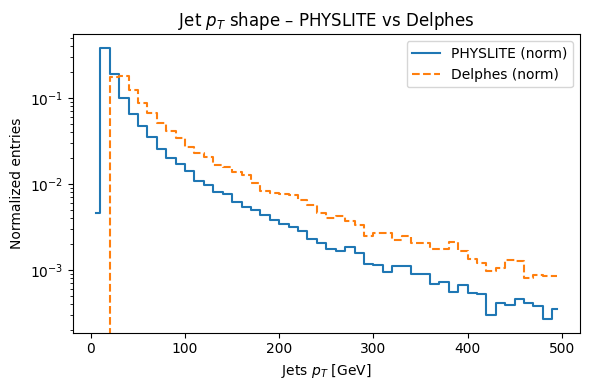

In [30]:
phy_pt_norm      = pt_hist_jet      / pt_hist_jet.sum()
delphes_pt_norm  = delphes_pt_hist / delphes_pt_hist.sum()

bin_centers_pt = 0.5 * (pt_bins[:-1] + pt_bins[1:])

plt.figure(figsize=(6, 4))
plt.step(bin_centers_pt, phy_pt_norm,     where="mid", label="PHYSLITE (norm)")
plt.step(bin_centers_pt, delphes_pt_norm, where="mid", linestyle="--", label="Delphes (norm)")
plt.yscale("log")
plt.xlabel("Jets $p_T$ [GeV]")
plt.ylabel("Normalized entries")
plt.title("Jet $p_T$ shape – PHYSLITE vs Delphes")
plt.legend()
plt.tight_layout()
plt.show()


We can see that Delphes reproduces the overall falling pT trend, but the spectrum is systematically higher: it underestimates low pT jets and overestimates high pT jets compared to PHYSLITE. This is can be good enough for qualitative studies, but it introduces a bias for analyses sensitive to the jet pT shape.

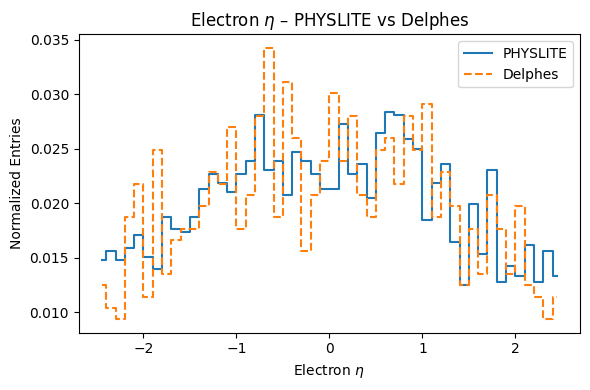

In [31]:
phy_eta_norm      = eta_hist_el      / eta_hist_el.sum()
delphes_eta_norm  = delphes_eta_hist / delphes_eta_hist.sum()
eta_centers = 0.5 * (eta_bins[:-1] + eta_bins[1:])

plt.figure(figsize=(6, 4))
plt.step(eta_centers, phy_eta_norm, where="mid", label="PHYSLITE")
plt.step(eta_centers, delphes_eta_norm, where="mid", linestyle="--", label="Delphes")

plt.xlabel("Electron $\\eta$")
plt.ylabel("Normalized Entries")
plt.title("Electron $\\eta$ – PHYSLITE vs Delphes")
plt.legend()
plt.tight_layout()
plt.show()

Similarly, we can see that with Delphes we get an overal shape that's similar. In this case, t overestimates the electron occupancy in some η regions and underestimates it in others and underestimate others. This leads to bin differences even though the global trend is similar.

This reflect the fact that Delphes uses a simplified detector model and generic object definitions, rather than the full ATLAS reconstruction and calibrations encoded in PHYSLITE. This level of agreement is usually sufficient for proof of concept studies or teaching examples, but it also illustrates an important limitation: fast simulation cannot exactly reproduce the behaviour of the reconstructed objects. For precision measurements or analyses that rely on subtle shape differences, dedicated simulations and object definitions are still required.

Here are a few specific things you could try with these samples:
* Plot the electrons multiplicity
* Find another sample that is both in our PHYSLITE data and the event generation data and use it to plot. Compare with the results here, do you see any difference?

<div class="alert alert-block alert-info">
We welcome your feedback on this notebook or any of our other materials! Please <a href=\"https://forms.gle/zKBqS1opAHHemv9U7\">fill out this survey</a> to let us know how we're doing, and you can enter a raffle to win some <a href=\"https://atlas-secretariat.web.cern.ch/merchandise\">ATLAS merchandise</a>!
</div>